##### <u> Part 1: Adding label </u>

In [3]:
from collections import Counter
import re
class optimized_ml_to_sl:
    def __init__(self,ml_data):
        data,temp=[],''
        for i in ml_data:
            if i.startswith('>'):
                data.append(temp)
                data.append(i.rstrip())
                temp=''
            else:
                temp=temp+i.rstrip()
        data.append(temp)
        self.sl_seq=data[1:]      
# a=optimized_ml_to_sl(temp_data).sl_seq
# a
class label_fasta:
    def __init__(self,data):
        self.label_data={} ################################ this varible will be update ################################
        self.dup={}
        self.intra_dup_count=0
        for i,j in data.items():
            temp=[]
            with open(i,'r') as inpt:
                for k in inpt:
                    temp.append(k.rstrip())
            new_temp=optimized_ml_to_sl(temp).sl_seq ############ Multi line to single line ############################
            self.label_data[j]={}
            self.dup[j]=[]
            for l in range(0,len(new_temp),2):
                try:
                    self.label_data[j][new_temp[l]]
                    self.dup[j].append(new_temp[l]) ############ remove dulpicates within the family #####################
                except KeyError:
                    self.label_data[j][new_temp[l]]=new_temp[l+1]
#                     print(new_temp[l+1])
            print(f'{j} Intra family Total:{int(len(new_temp)/2)}, No_dup:{len(self.label_data[j])}, Dup:{len(self.dup[j])}')
#             print(len(self.dup[j]))
            self.intra_dup_count+=len(self.dup[j])
        self.inter_fam_dup()
        self.UZOBJX()
        self.label()
        
    def inter_fam_dup(self):
        tot_key=[]
        self.inter_dup_count=0
        for i in self.label_data.keys():
            tot_key.extend(list(self.label_data[i].keys()))
        temp=dict(Counter(tot_key))
        self.inter_remove=[j for j in temp.keys() if temp[j]>1] ########### 1 represent acc occuring more than 1 family ####
        temp=self.label_data.keys()
        for k in list(temp):
            x=len(self.label_data[k])
            for l in self.inter_remove:
                del self.label_data[k][l] ############## Removes the accession number which occur in more than 1 family #####
            y=len(self.label_data[k])
            print(f'{k} Inter family Total:{x}, No_dup:{y}, Dup:{x-y}')
            self.inter_dup_count+=(x-y)
            
    def UZOBJX(self):
        self.uzobjx=[]
        self.tot_uzobjx=0
        for i in self.label_data.keys():
#             print(i)
            x=len(self.label_data[i].keys())
            temp=self.label_data[i].keys()
            for j in list(temp):
                if re.search('[UZOBJX]',self.label_data[i][j]):
                    self.uzobjx.append(j)
                    del self.label_data[i][j] ####################### Delete sequences which have UZOBJX ####################
            y=len(self.label_data[i].keys())
            print(f'{i} AA Total:{x}, AA:{y}, UZOBJX:{x-y}')
            self.tot_uzobjx+=x-y
#         print('Total removed:',self.tot_uzobjx)
            
    def label(self):
        self.acc, self.seq, self.min_l= [], [], [] #################### acc, seq, min_length of protein sequence ############
        self.all_len={}
        for i in self.label_data.keys():
            self.all_len[i]=[]
            for j,k in self.label_data[i].items():
                self.acc.append(j+'$'+i)
                self.seq.append(k)
                self.all_len[i].append(len(k))
                self.min_l.append(len(k))
        print(f'Total acc:{len(self.acc)}')
        print(f'Total seq:{len(self.seq)}')
        
# bert=label_fasta(files_labele)

In [12]:
files_labele={'Ferredoxin_TrEMBL/FDX1_Tr.fasta':'FDX1','Ferredoxin_TrEMBL/FDX2_Tr.fasta':'FDX2'}

In [4]:
import matplotlib.pyplot as plt
from collections import defaultdict

class length_filter:
    def __init__(self,acc2,seq2,tot_len,lab_key):
        co=boxplt_len_filt(tot_len,lab_key)
        self.acc,self.seq=[],[]
        self.test=defaultdict(list)
        for i in range(len(acc2)):
            j=acc2[i].split('$')[-1]
            if len(seq2[i])>=co.cut_off[j][0] and len(seq2[i])<=co.cut_off[j][1]:
                self.acc.append(acc2[i])
                self.seq.append(seq2[i])
                self.test[j].append(len(seq2[i]))
        print(f'Total number of entries before length cut-off:{len(acc2)}')
        print(f'Total number of entries after length cut-off:{len(self.acc)}')

class boxplt_len_filt:
    def __init__(self,tot_len,lab_key):
        fig=plt.figure(figsize=(10,7))
        lab_=list(lab_key.values())
        daa=plt.boxplot([tot_len[bsbe] for bsbe in lab_], labels=lab_)
        plt.xlabel('Ferredoxin')
        plt.ylabel('Lenght of the sequences')
        plt.title('Sequence length distribution')
        plt.show()
        self.cut_off={}
        caps=[cap.get_ydata() for cap in daa['caps']]
        part=int(len(caps)/2)
        cd=0
        for uy in lab_:
            ttt=[]
            for vy in caps[cd:part]:
                ttt.append(int(vy[0]))
            self.cut_off[uy]=ttt
            cd+=part
            part+=part
        print(self.cut_off)
# len_filter=length_filter(a.acc,a.seq)

##### <u> Part 2: Extracting feature from protein sequences </u>

In [5]:
import numpy as np
from scipy import stats
import pandas as pd
import re

# 1: Hydrophobicity, 2: Hydrophilicity, 3: mass, 4: pk1, 5: pk2, 6:pi, 20: 14 scale, 60: Tanford
class Standard_values:
    def __init__(self,filename):
        self.data=[]
        with open(filename,'r') as inpt:
            for each in inpt:
                self.data.append(each.rstrip().split(','))
        del self.data[0]
        
    def get_prop(self,prop):
        got_prop,amino_acid={},{}
        for each in prop:
            got_prop[each]=self.properties(each)
        d=1
        for each in got_prop[1].keys():
            amino_acid[d]=each
            d+=1
        return amino_acid,got_prop
    
    def properties(self, val):
        temp,norm={},{}
        for each in self.data:
            temp[each[0]]=float(each[val])
        relative=stats.zscore(np.array(list(temp.values())))
        for a,b in zip(temp.keys(),relative):
            norm[a]=b
        return norm

class Pseaac:
    def __init__(self,filename,acc1,seq1):
        self.filename=filename
        self.acc1,self.seq1=acc1,seq1
    def collect(self,lamb,w,pro,nf):
        val=[]
        val.append(['#']+[ea for ea in keys.values()]+['\u03BB'+str(eac+1) for eac in range(lamb)])
        for e_seq in range(len(self.seq1)):# single sequence taken for test
            q=self.pse(self.seq1[e_seq],lamb,w,pro,nf)
            tem=self.acc1[e_seq].split(' ')[0][1:]
            val.append([self.acc1[e_seq]]+q)
        df=pd.DataFrame(val[1:],columns=val[0])
#         print('PseAAC feature have been extracted!!!')
        return df
        
    def pse(self,data,lamb,w,pro,nf):
        thet=self.theta(data,lamb,pro)
        deno=1+(w*sum(thet.values()))
        p=[]
        if nf==1:
            norm=(len(data))
        else:
            norm=1
        for u in range(1,21+lamb):
            if u>=1 and u<=20:
    #             print(u,'natural')
                num=data.count(keys[u])/norm # frequency
                p.append(num/deno)
            elif u>=21 and u<=20+lamb:
    #             print(u,'pseudo')
                num=w*thet[u-20]
                p.append(num/deno)
        return p
    
    def theta(self,data,lamb,pro):
        the={}
        for u in range(1,lamb+1):
            the[u]=(1/(len(data)-u))*self.rel_cal(data,u,pro)
        return the
    
    def rel_cal(self,data,v,pro):
        tem=[]
        for u in range(len(data)-v):
            te=[]
            for u1 in pro:
                x=((values[u1][data[u]])-(values[u1][data[u+v]]))**2
                te.append(x)
    #             print(u1,u,u+v,data[u],data[u+v],x)
            tem.append(sum(te)/len(pro))
        return sum(tem)

keys,values=Standard_values('D:/After_4_4_22/Project_1_Part_1/CAZy_23_6_22/7_98_hydrophobicity.csv').get_prop([1,2,3,4,5,6,20,60])
# pseaac_data['Length']=stats.zscore(min_len)

In [6]:
class score:
    def __init__(self,size):
        self.ground=self.get_indexes(size[0])
        self.predict=self.get_indexes(size[1])
        TP=np.dot(self.ground,self.predict)
        TN=np.dot((self.ground==0).astype(float),(self.predict==0).astype(float))
        FP=np.dot((self.ground==0).astype(float),self.predict)
        FN=np.dot(self.ground,(self.predict==0).astype(float))
        self.points={'TP':TP,'TN':TN,'FP':FP,'FN':FN}
    
    def get_indexes(self,data):
        ind=((np.expand_dims(data,axis=0))==(np.expand_dims(data,axis=1))).astype(int)
        ind=ind[np.triu_indices(len(data),k=1)]
        return ind
      
# a=score(100000,2)

class methad:
    def __init__(self,data):
        self.temp=self.formula(data)
    def formula(self,d):
        mcc_num=(d['TP']*d['TN'])-(d['FP']*d['FN'])
        mcc_deno=(d['TP']+d['FP'])*(d['TP']+d['FN'])*(d['TN']+d['FP'])*(d['TN']+d['FN'])
        if mcc_deno==0:
            mcc=0
        else:
            mcc=(mcc_num)/(mcc_deno**0.5)
        fmi=d['TP']/(((d['TP']+d['FP'])*(d['TP']+d['FN']))**0.5)
        rpi=((d['TP']*d['TN'])/((d['TP']+d['FN'])*(d['TN']+d['FP'])))**0.5
        precisio=d['TP']/(d['TP']+d['FP'])
        recal=d['TP']/(d['TP']+d['FN'])
        F1_num=2*(precisio*recal)
        F1_deno=precisio+recal
        if F1_deno==0:
            f1=0.0
        else:
            f1=F1_num/F1_deno
        acc=(d['TP']+d['TN'])/(d['TP']+d['TN']+d['FP']+d['FN'])
        return {'FMI':fmi,'RPI':rpi,'Pr':precisio,'Re':recal,'F1':f1,'ACC':acc,'MCC':mcc}
# nes=methad(a)

In [7]:
'''Clustering Algorithm'''
import os
import time
import matplotlib.pyplot as plt
from sklearn import cluster, mixture, manifold, decomposition, preprocessing,metrics
import random
from collections import Counter,defaultdict
import copy

class clustering:
    rs=77
#     rn=random.randint(1,99)
    def __init__(self,folder,train_data,test_data,n,cat):
        self.x_train=train_data.iloc[:,1:].values
        self.y_train=train_data.iloc[:,0]
        self.x_test=test_data.iloc[:,1:].values
        self.y_test=test_data.iloc[:,0]
        self.folder=folder
        self.cat=cat
        self.anno_label={0:'acc',1:'prtn',2:'ec',3:'org',4:'species',5:'ghf',14:'gpcr_nongpcr_tem',9:'grafs',10:'class'}
        temp=[i.split('$')[cat[0]] for i in self.y_test]
        lab=list(set(temp))
        self.true_lab=[lab.index(j) for j in temp]
        try:
            n.isalpha()
            self.n=len(lab)
        except AttributeError:
            self.n=n
        self.temp1=','.join([f'{k}:{v}' for k,v in dict(Counter(temp)).items()])
        
    def kmeans(self):
        start = time.time()
        self.names = 'km'
        kmeans = cluster.KMeans(n_clusters=self.n,random_state=clustering.rs).fit(self.x_train) # Number of clusters
        self.labels = kmeans.predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def affinity(self):
        start = time.time()
        self.names = 'apc'
        apc = cluster.AffinityPropagation(random_state=clustering.rs).fit(self.x_train)
        self.labels = apc.predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def meanshift(self):
        start = time.time()
        self.names = 'ms'
        ms = cluster.MeanShift().fit(self.x_train)
        self.labels = ms.predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def spectral(self): # No predict
        start = time.time()
        self.names = 'spec'
        spectral = cluster.SpectralClustering(n_clusters=self.n,affinity='nearest_neighbors',assign_labels="discretize",random_state=clustering.rs) # Number of clusters
        self.labels = spectral.fit_predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def agglomerative(self): # No predict
        start = time.time()
        self.names = 'agglo'
        agglo = cluster.AgglomerativeClustering(n_clusters=self.n) # Number of clusters
        self.labels = agglo.fit_predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def dbscan(self): # No predict
        start = time.time()
        self.names = 'dbs'
        new_x=preprocessing.StandardScaler().fit_transform(self.x_test)
        dbs = cluster.DBSCAN()
        self.labels = dbs.fit_predict(new_x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def optics(self): # No predict
        start = time.time()
        self.names = 'opt'
        opt = cluster.OPTICS()
        self.labels = opt.fit_predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def gaussian(self):
        start = time.time()
        self.names = 'gm'
        gm = mixture.GaussianMixture(n_components=self.n,random_state=clustering.rs).fit(self.x_train) # Number of Clusters
        self.labels = gm.predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def birch(self):
        start = time.time()
        self.names = 'bir'
        brc = cluster.Birch().fit(self.x_train) # Number of clusters
        self.labels = brc.predict(self.x_test)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()

    def label_save(self):
        dfout = pd.DataFrame({'Accession': self.y_test,  'predicted': self.labels, 'expected':self.true_lab})
        try:
            os.mkdir(self.folder)
        except FileExistsError:
            pass
        dfout.to_csv(f'{self.folder}\ML_{self.names}_{len(set(self.labels))}.txt',sep='\t', index=False)
        self.file()
        return self.analysis()
    
    def analysis(self):
        value=metrics.fowlkes_mallows_score(self.true_lab,self.labels)
        ami=str(round(metrics.adjusted_mutual_info_score(self.true_lab,self.labels),3))
        pn=score([self.true_lab,self.labels]).points
        sss=sum(pn.values())
        new_pn=[str(round(ve/sss,2)) for ve in pn.values()]
        new_value=methad(pn).temp
        new_value=[str(round(we,3)) for we in new_value.values()]
        tot_val=[self.names,self.anno_label[self.cat[0]],str(test_lambda),str(self.n),str(len(set(self.labels)))]+new_pn+new_value+[ami]+[self.temp1,str(len(self.true_lab))]
        return tot_val
    
    def file(self):
        try:
            os.mkdir(f'{self.folder}/table')
        except FileExistsError:
            pass
        dd=defaultdict(list)
        for i in range(len(self.labels)):
            dd[self.labels[i]].append(self.y_test[i])
        self.excel(dict(sorted(dd.items())))
        
    def excel(self,anno):
        all_anno={}
        for i in self.cat:
            temp={}
            for j,k in anno.items():
                te=[]
                for l in k:
                    te.append(l.split('$')[i])
                temp[j]=dict(Counter(te))
            df=pd.DataFrame(temp).fillna(0).astype(int)
            df.loc['Total']=df.sum(axis=0)
            df.loc[:,'Total']=df.sum(axis=1)
            df.to_excel(f'{self.folder}/table/{self.names}_{len(set(self.labels))}_{self.anno_label[i]}.xlsx')

In [8]:
class remove_acc:
    def __init__(self, ac,se, rm_acc):
        self.rm=rm_acc
        ddd=len(rm_acc)
        self.new_acc,self.new_seq=[],[]
        ccc=0
        for i in range(len(ac)):
            if self.check_(ac[i]):
                ccc+=1
            else:
                self.new_acc.append(ac[i])
                self.new_seq.append(se[i])
                
        if ccc==ddd:
            print(f'Successfully removed {ccc} accession IDs')
        else:
            print(f'Unsuccessfully in removing {ddd-ccc} accession IDs')
    def check_(self,accession):
        j=0
        for i in self.rm:
            if accession.startswith(i):
                self.rm.remove(i)
                j+=1
                break
        return j

FDX1 Intra family Total:10, No_dup:10, Dup:0
FDX2 Intra family Total:8, No_dup:8, Dup:0
FDX1 Inter family Total:10, No_dup:10, Dup:0
FDX2 Inter family Total:8, No_dup:8, Dup:0
FDX1 AA Total:10, AA:10, UZOBJX:0
FDX2 AA Total:8, AA:8, UZOBJX:0
Total acc:18
Total seq:18
Sequence has been collected for FDX1_FDX2....
Successfully removed 2 accession IDs
Feature has been extracted for FDX1_FDX2....
FDX1 Intra family Total:1296, No_dup:1296, Dup:0
FDX2 Intra family Total:610, No_dup:610, Dup:0
FDX1 Inter family Total:1296, No_dup:1257, Dup:39
FDX2 Inter family Total:610, No_dup:571, Dup:39
FDX1 AA Total:1257, AA:1247, UZOBJX:10
FDX2 AA Total:571, AA:568, UZOBJX:3
Total acc:1815
Total seq:1815


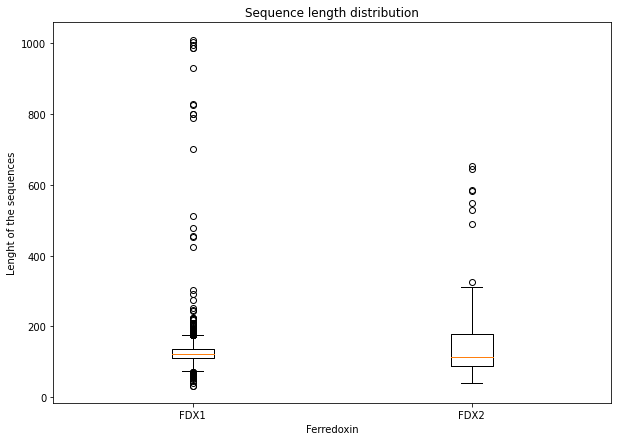

{'FDX1': [75, 175], 'FDX2': [40, 311]}
Total number of entries before length cut-off:1815
Total number of entries after length cut-off:1612
Sequence has been collected for FDX1_FDX2....
Feature has been extracted for FDX1_FDX2....


c:\users\rakes\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Clustering has been done for FDX1_FDX2....
Mission completed in 17.363 seconds


c:\users\rakes\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_birch.py:647: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (3). Decrease the threshold.
  warnings.warn(


In [38]:
import os
import time
from collections import defaultdict
# '1' stands for single domain, and 'm' stands for to include mutli domain in single domain sequences

######## Chnage the folder name before running the programm ############
protein_naav='FDX1_FDX2'
main_file='Ferredoxin_train_test_sp_tr'
os.mkdir(main_file)

position=1 ################################################################ change the position according to the label
t1=time.perf_counter()
class fetch_PAAC:
    def __init__(self,file_dic,prt_name,rm,_len_):
        self.prt_name=prt_name
        a=label_fasta(file_dic)
        if _len_:
            len_outliers=length_filter(a.acc,a.seq,a.all_len,file_dic)
            self.acc,self.seq,self.min_len,self.x_aa,self.intra_dup,self.inter_dup=len_outliers.acc,len_outliers.seq,a.min_l,a.tot_uzobjx, a.intra_dup_count,a.inter_dup_count
        else:
            self.acc,self.seq,self.min_len,self.x_aa,self.intra_dup,self.inter_dup=a.acc,a.seq,a.min_l,a.tot_uzobjx, a.intra_dup_count,a.inter_dup_count
        print(f'Sequence has been collected for {self.prt_name}....')
        
        if rm:
            rm_data=remove_acc(self.acc,self.seq,rm)
            self.acc,self.seq=rm_data.new_acc,rm_data.new_seq
        
        min_lamb=30
        try:
            if min(self.min_len)<min_lamb:
                lambda_value=min(self.min_len)-1
            else:
                lambda_value=min_lamb
        except ValueError:
            print(self.prt_name,': doesnt have sequences')
#         print(lambda_value)
        
        self.pseaac_data=Pseaac(f'PAAC_{self.prt_name}_L{lambda_value}.txt',self.acc,self.seq).collect(lambda_value,0.05,[60,2,3],1)
        self.lambda_value=lambda_value
        print(f'Feature has been extracted for {self.prt_name}....')
        
train_label={'FXD1_swissprot.fasta':'FDX1','FXD2_swissprot.fasta':'FDX2'}
train_rm=['>sp|O67065','>sp|O67232']
train_fasta=fetch_PAAC(train_label,protein_naav,train_rm,0)
train_PAAC=train_fasta.pseaac_data

is_train_and_test_same=0 ###################################################################

if is_train_and_test_same:
    test_label=train_label
    test_rm=train_rm
    test_fasta=train_fasta
    test_PAAC=train_fasta.pseaac_data
    test_lambda=train_fasta.lambda_value
else:
    test_label={'Ferredoxin_TrEMBL/FDX1_Tr.fasta':'FDX1','Ferredoxin_TrEMBL/FDX2_Tr.fasta':'FDX2'}
    test_rm=[]
    test_fasta=fetch_PAAC(test_label,protein_naav,test_rm,1)
    test_PAAC=test_fasta.pseaac_data
    test_lambda=test_fasta.lambda_value
# In the below statement 'auto' means it takes automatic clusters based on number labels given, you can also choose any number.
clust=clustering(f'{main_file}/{protein_naav}_clust',train_PAAC,test_PAAC,'auto',[position]) # 0:'acc',1:'prtn',2:'ec',3:'org',4:'species',5:'ghf'
try:
    km=clust.kmeans()
    apc=clust.affinity()
    ms=clust.meanshift()    
    spec=clust.spectral()
    agglo=clust.agglomerative()
    dbs=clust.dbscan()
    opt=clust.optics()
    gm=clust.gaussian()
    bir=clust.birch()
except ValueError:
    print(f'{protein_naav} has {len(train_fasta.acc)} samples which is less than 5 min_samples ')
    value_error.append([protein_naav,len(train_fasta.acc)])
print(f'Clustering has been done for {protein_naav}....')
all_clust={'km':km,'apc':apc,'ms':ms,'spec':spec,'agglo':agglo,'dbs':dbs,'opt':opt,'gm':gm,'bir':bir}
total_data=[]
for aa in all_clust.values():
#         print(aa)
    bb=[protein_naav]+aa+[str(test_fasta.x_aa)]+[str(test_fasta.intra_dup),str(test_fasta.inter_dup)]
    total_data.append('$'.join(bb))
t2=time.perf_counter()
print('Mission completed in',round(t2-t1,3),'seconds')

In [39]:
from tqdm import tqdm
all_metric=['FMI','RPI','Pr','Re','F1','ACC','MCC']
tfpn=['TP','TN','FP','FN']
titl=['EC_number','Method','label_type','l','exp','pred']+tfpn+all_metric+['AMI']+['distribution','total','X_aa','Intra_dup','Inter_dup']
outpt=open('ferridoxin_train_test_sp_tr_summary.txt','w')
outpt.write('$'.join(titl)+'\n')
for line in tqdm(total_data):
    outpt.write(line+'\n')
outpt.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]
